## Overfit and Underfit

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import tensorflow_docs as docs
from tensorflow_docs import modeling
from tensorflow_docs import plots

from IPython import display
import matplotlib.pyplot as plt
import pathlib
import shutil
import pandas as pd 
import tempfile

In [2]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

### Download and Explore the Dataset

In [3]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816409600/2816407858 [==============================] - 1451s 1us/step


In [4]:
FEATURES = 28

In [5]:
ds = tf.data.experimental.CsvDataset(gz, [float(),]*(FEATURES+1), compression_type='GZIP')

In [6]:
def pack_row(*row):
    label = row[0]
    featurs = tf.stack(row[1:],1)
    return featurs, label

In [7]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


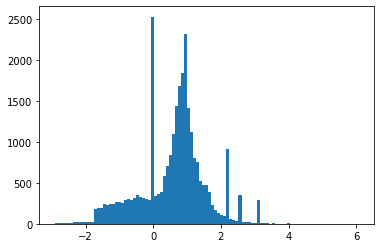

In [9]:
for features,label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins=101)

In [10]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [11]:
# ensure that the loader doesn't need to re-read the data from the file on each epoch:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [12]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [13]:
# create batches of an appropriate size for training. Before batching also remember 
# to shuffle and repeat the training set.
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

### Training Procedure

In [14]:
# hyperbolically decrease the learning rate to 1/2 of the base rate at 1000 epochs,
# 1/3 at 2000 epochs and so on.
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.001,
                                                             decay_steps=STEPS_PER_EPOCH*1000,
                                                             decay_rate=1,
                                                             staircase=False)
def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

Text(0, 0.5, 'Learning Rate')

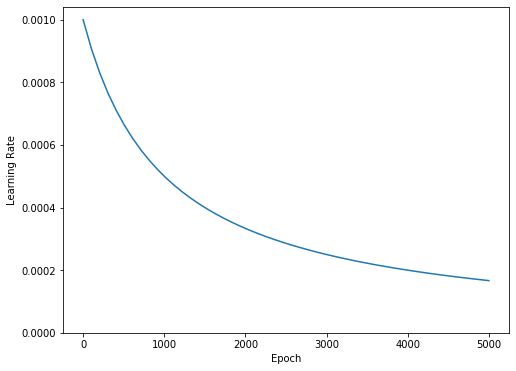

In [15]:
import numpy as np

step = np.linspace(0, 100000)
lr = lr_schedule(step)
plt.figure(figsize=(8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")

In [17]:
def get_callbacks(name):
    return [
        docs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
        tf.keras.callbacks.TensorBoard(logdir/name),
    ]

In [38]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                              name='binary_crossentropy'),
                           'accuracy'])
    #model.summary()
    
    history = model.fit(train_ds,
                        steps_per_epoch= STEPS_PER_EPOCH,
                        epochs=max_epochs,
                        validation_data=validate_ds,
                        callbacks=get_callbacks(name),
                        verbose=0)
    return history

In [39]:
# Start by a tiny model
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

In [40]:
size_histories = {}

In [41]:
size_histories['tiny_model'] = compile_and_fit(tiny_model, 'sizes/tiny')


Epoch: 0, accuracy:0.4761,  binary_crossentropy:0.7689,  loss:0.7689,  val_accuracy:0.4750,  val_binary_crossentropy:0.7464,  val_loss:0.7464,  
....................................................................................................
Epoch: 100, accuracy:0.5964,  binary_crossentropy:0.6257,  loss:0.6257,  val_accuracy:0.5880,  val_binary_crossentropy:0.6334,  val_loss:0.6334,  
....................................................................................................
Epoch: 200, accuracy:0.6178,  binary_crossentropy:0.6140,  loss:0.6140,  val_accuracy:0.6140,  val_binary_crossentropy:0.6221,  val_loss:0.6221,  
....................................................................................................
Epoch: 300, accuracy:0.6365,  binary_crossentropy:0.6012,  loss:0.6012,  val_accuracy:0.6250,  val_binary_crossentropy:0.6077,  val_loss:0.6077,  
....................................................................................................
Epoch: 40

(0.5, 0.7)

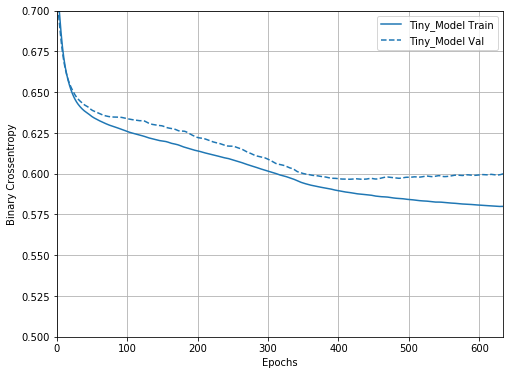

In [43]:
plt.figure(figsize=(8,6))
plotter = docs.plots.HistoryPlotter(metric= 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5,0.7])

In [45]:
# small model
small_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [46]:
size_histories['small_model'] = compile_and_fit(small_model, 'sizes/small')


Epoch: 0, accuracy:0.4895,  binary_crossentropy:0.7529,  loss:0.7529,  val_accuracy:0.4650,  val_binary_crossentropy:0.7081,  val_loss:0.7081,  
....................................................................................................
Epoch: 100, accuracy:0.6355,  binary_crossentropy:0.6100,  loss:0.6100,  val_accuracy:0.6150,  val_binary_crossentropy:0.6162,  val_loss:0.6162,  
....................................................................................................
Epoch: 200, accuracy:0.6750,  binary_crossentropy:0.5853,  loss:0.5853,  val_accuracy:0.6470,  val_binary_crossentropy:0.5916,  val_loss:0.5916,  
....................................................................................................
Epoch: 300, accuracy:0.6804,  binary_crossentropy:0.5745,  loss:0.5745,  val_accuracy:0.6630,  val_binary_crossentropy:0.5838,  val_loss:0.5838,  
....................................................................................................
Epoch: 40

In [47]:
# medium model
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [48]:
size_histories['medium_model'] = compile_and_fit(medium_model, 'sized/medium')


Epoch: 0, accuracy:0.4787,  binary_crossentropy:0.6998,  loss:0.6998,  val_accuracy:0.4760,  val_binary_crossentropy:0.6749,  val_loss:0.6749,  
....................................................................................................
Epoch: 100, accuracy:0.7144,  binary_crossentropy:0.5299,  loss:0.5299,  val_accuracy:0.6690,  val_binary_crossentropy:0.6086,  val_loss:0.6086,  
....................................................................................................
Epoch: 200, accuracy:0.7814,  binary_crossentropy:0.4355,  loss:0.4355,  val_accuracy:0.6360,  val_binary_crossentropy:0.6998,  val_loss:0.6998,  
......................................................................

In [49]:
# large Model
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [50]:
size_histories['large_model'] = compile_and_fit(large_model, 'sizes/large')


Epoch: 0, accuracy:0.5115,  binary_crossentropy:0.8102,  loss:0.8102,  val_accuracy:0.5270,  val_binary_crossentropy:0.6641,  val_loss:0.6641,  
....................................................................................................
Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0026,  loss:0.0026,  val_accuracy:0.6680,  val_binary_crossentropy:1.6741,  val_loss:1.6741,  
....................................................................................................
Epoch: 200, accuracy:1.0000,  binary_crossentropy:0.0001,  loss:0.0001,  val_accuracy:0.6660,  val_binary_crossentropy:2.3359,  val_loss:2.3359,  
............................

Text(0.5, 0, 'Epochs [Log Scale]')

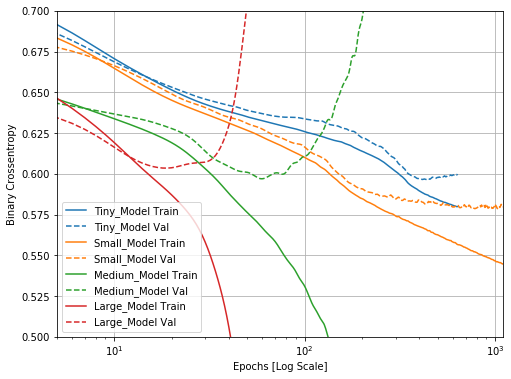

In [51]:
plt.figure(figsize=(8,6))
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [52]:
%tensorboard --logdir {logdir}/sizes

UsageError: Line magic function `%tensorboard` not found.
